# Analysis of results from AOMA logged at h5 file

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
import os

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
loader = dl.HDF5_result_loader(path=os.getcwd()+'/../Referencebased_Cov-SSI/results/output_5_AOMA.h5')

In [3]:
print(np.array(loader.hdf5_file[loader.periods[0]]['Frequencies']))

[0.0547043  0.05470445 0.11100697 0.14184092 0.20295992 0.22000591
 0.28792829 0.28800072 0.3532857  0.42951036 0.45038643 0.50943118
 0.59920233 0.62172618 0.69222665 0.79768512 0.79768578 0.93215189
 0.98479   ]


In [4]:
freqs = []
damping = []
num = []
temps = []
mean_wind = []
max_wind = []
execution_time = []
high_freqs = []
low_mode_damping = []

counter = 0
for period in loader.periods:
    counter += 1
    frequencies = np.array(loader.hdf5_file[period]['Frequencies'])
    damp = np.array(loader.hdf5_file[period]['Damping'])
    freqs.extend(frequencies)
    damping.extend(damp)
    mean_wind.append(loader.hdf5_file[period].attrs['Mean wind speed'])
    max_wind.append(loader.hdf5_file[period].attrs['Max wind speed'])
    temps.append(loader.hdf5_file[period].attrs['Mean temp'])
    execution_time.append(loader.hdf5_file[period].attrs['Execution time'])
    num.extend(np.ones_like(frequencies)*counter)

    #pick element from frequencies with value closest to 0.8 Hz
    high_freqs.append(min(list(frequencies), key=lambda x:abs(x-0.8)))

    #pick element from damping from a low frequency mode
    low_mode_damping.append(damp[2])

In [15]:
#Load FEM results to use as a bench mark
hf = h5py.File(os.getcwd()+ '/../../../FEM/HalogalandModel_exportmodal.h5', 'r')
deck_modes_idx= np.array([1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 25, 32, 33, 34, 36, 37, 40, 45, 46, 48, 49, 50]) - 1# manually picked bridge deck modes from Abaqus model

f = np.array(hf.get('f'))
#filter_f = f<1
f = f[deck_modes_idx]
print((f))

[0.05386703 0.1159167  0.1198293  0.1441354  0.2058538  0.2175673
 0.2281544  0.2860988  0.348027   0.3974806  0.4243394  0.4380004
 0.4991885  0.5850167  0.5863821  0.5914302  0.6458548  0.6503595
 0.6898496  0.788882   0.8617281  0.8828331  0.8905289  0.9032722 ]


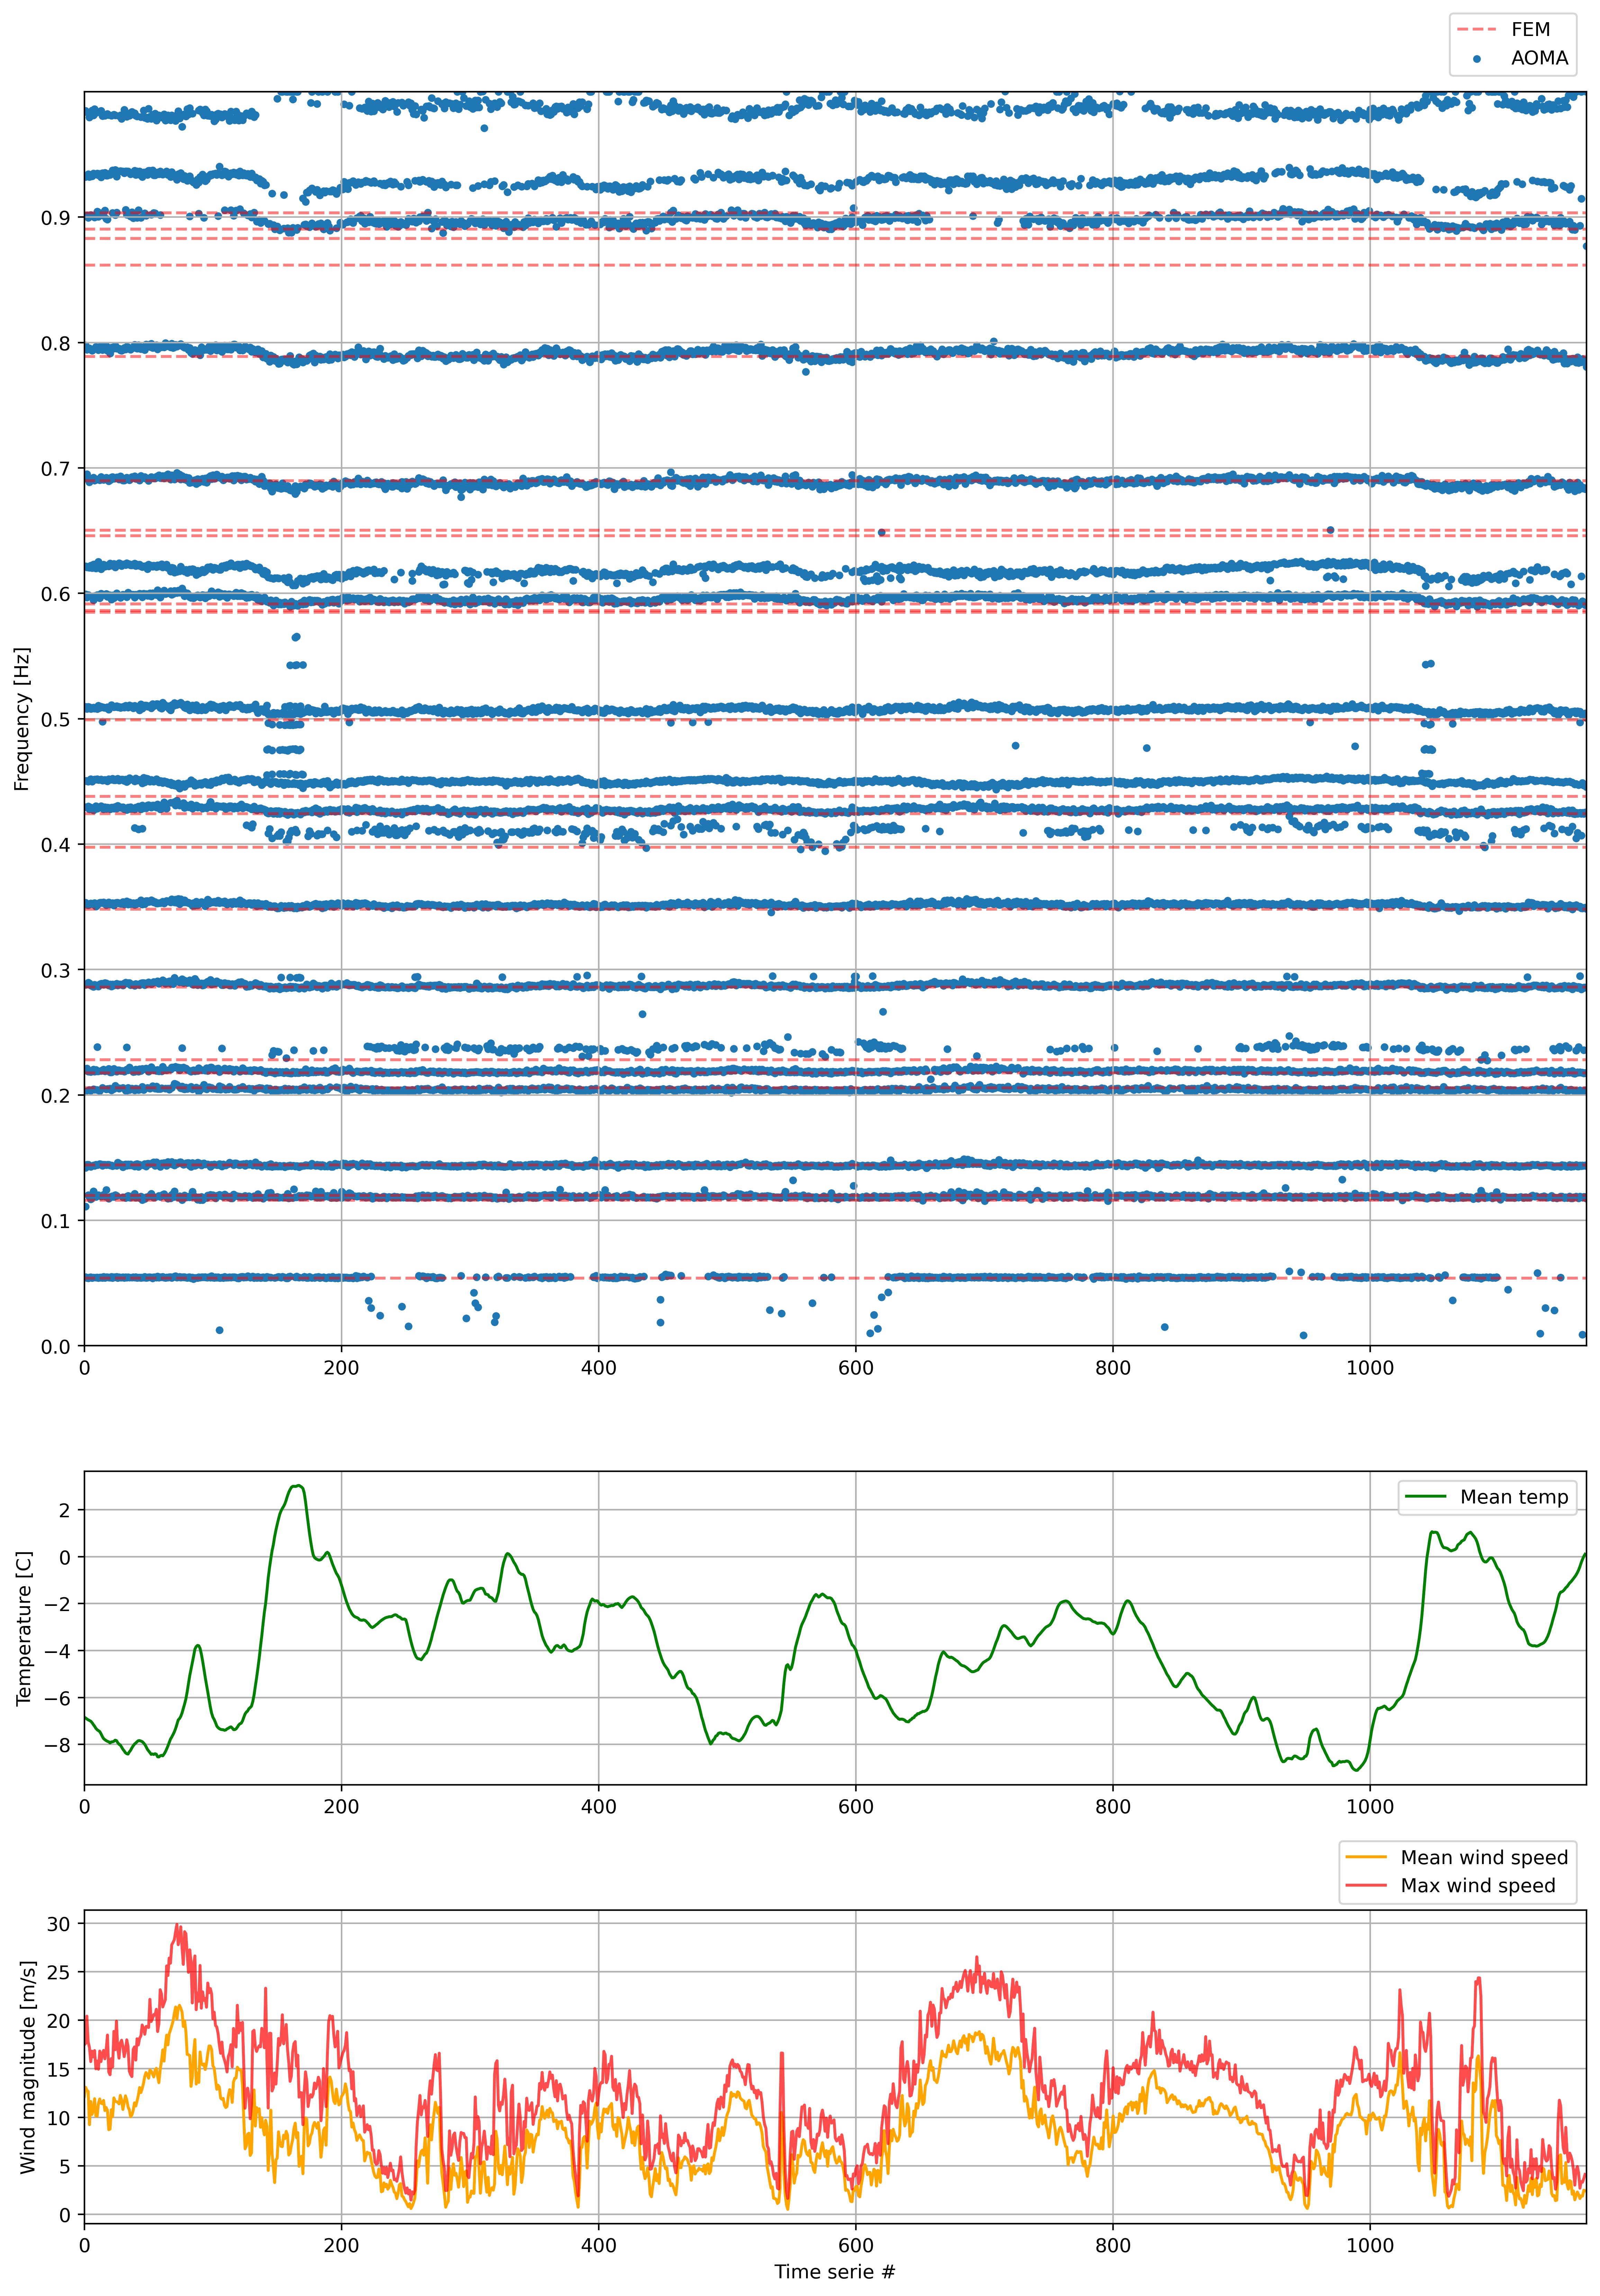

In [16]:
fig, (a1, a2, a3) = plt.subplots(3,1, figsize=(14, 20), dpi=400, gridspec_kw={'height_ratios': [8, 2, 2]})

a1.axhline(y = f[0], color='r', linestyle = '--', alpha = 0.5, label = 'FEM')
for i in range(len(f)-1):
    a1.axhline(y = f[i+1], color='r', linestyle = '--', alpha = 0.5)


a1.scatter(np.array(num), np.array(freqs), marker='.', label = 'AOMA')

a1.set_ylim((0,1))
a1.set_xlim((0, len(mean_wind)))
a1.set_ylabel('Frequency [Hz]')
a1.set_yticks(np.arange(0, 1, step=0.1))
a1.legend(loc = 'upper right', bbox_to_anchor=(1, 1.07))
plt.xlabel('Time serie #')
a1.grid()

#a2 = a1.twinx()
#a2.plot(np.arange(0, len(execution_time)), np.array(execution_time), label = 'Execution time')
a3.plot(np.arange(0, len(mean_wind)), np.array(mean_wind), label = 'Mean wind speed', color='orange')
a3.plot(np.arange(0, len(mean_wind)), np.array(max_wind), label = 'Max wind speed', color='red', alpha=0.7)
a3.set_xlim((0, len(mean_wind)))
a3.set_ylabel('Wind magnitude [m/s]')
a3.legend(loc = 'upper right', bbox_to_anchor=(1, 1.25))
a3.grid()

a2.plot(np.arange(0, len(temps)), np.array(temps), label = 'Mean temp', color='green')
a2.set_ylabel('Temperature [C]')
a2.set_xlim((0, len(mean_wind)))
a2.legend(loc = 'upper right')
a2.grid()
plt.savefig('plots/freq_vs_time.jpg')
plt.show()


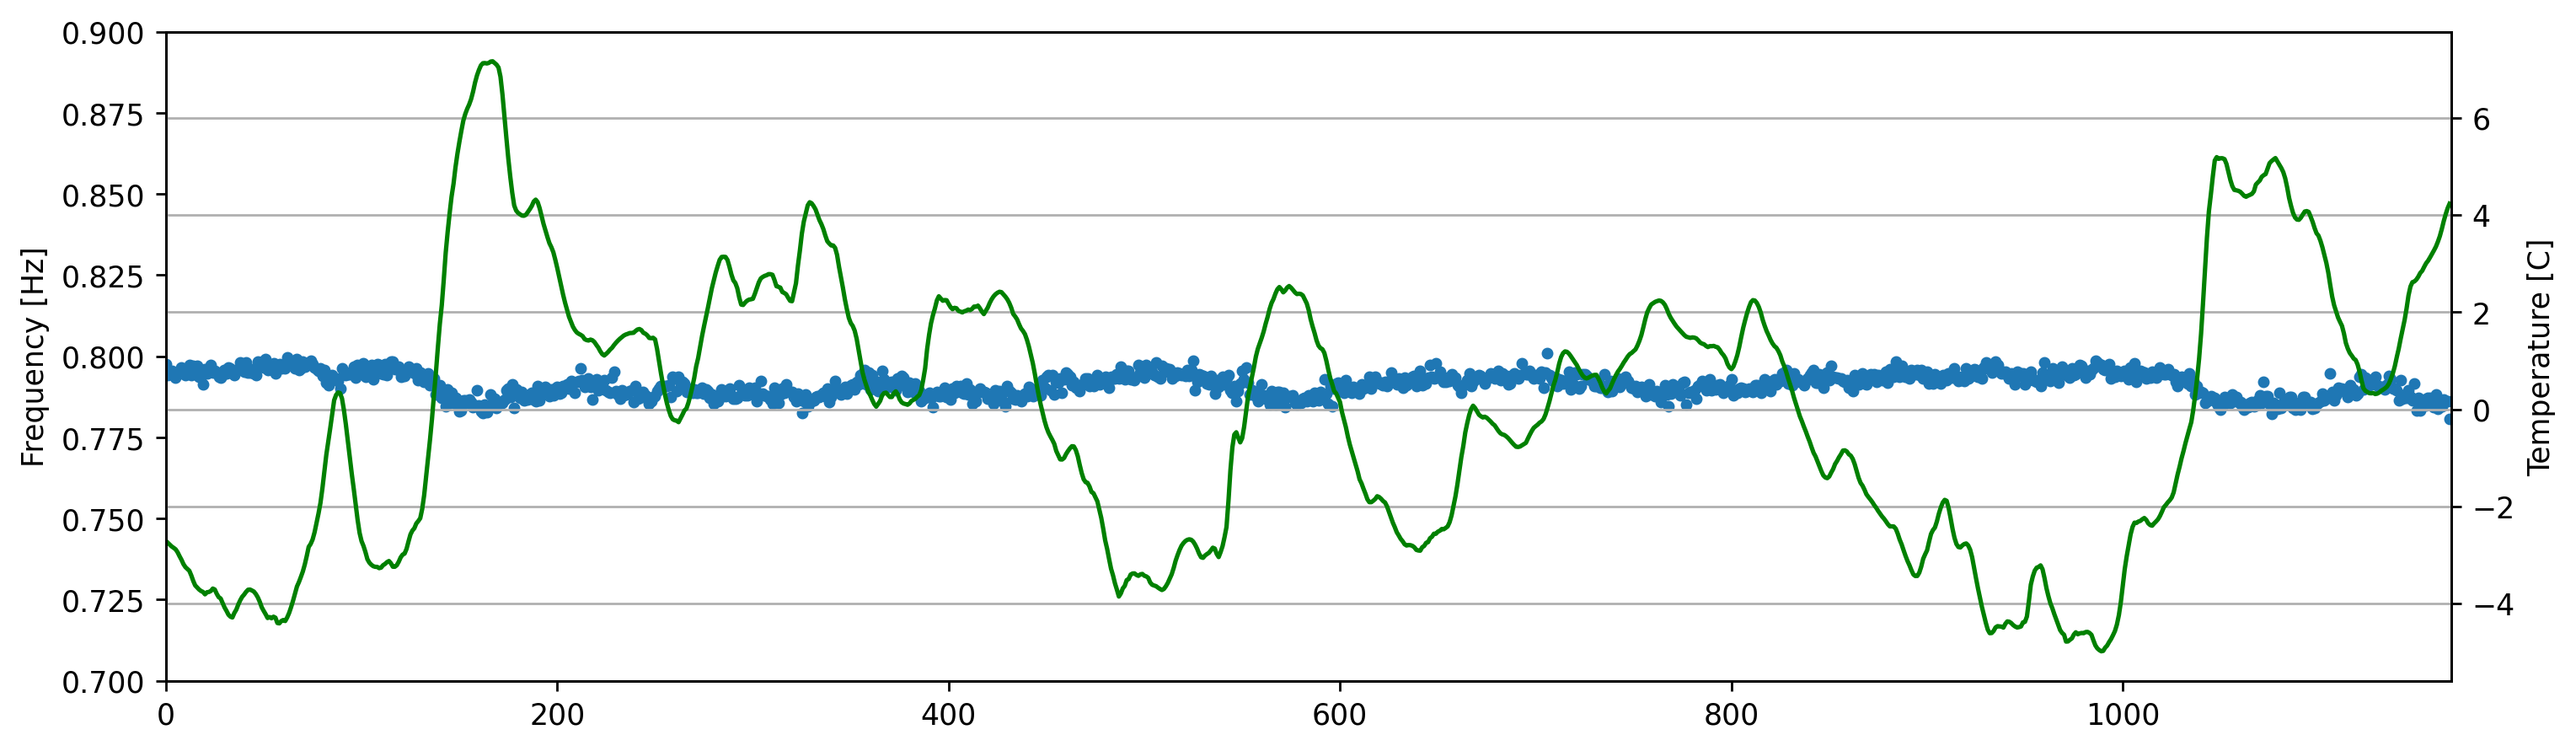

In [8]:
fig, ax1 = plt.subplots(figsize=(14,4), dpi=250)
ax1.scatter(np.arange(0, len(high_freqs)), np.array(high_freqs), marker='.', label = 'AOMA')
ax1.set_ylabel('Frequency [Hz]')
ax2 = plt.twinx()
ax2.plot(np.arange(0, len(temps)), np.array(temps) - np.mean(temps), label = 'Mean temp', color='green')
ax2.set_ylabel('Temperature [C]')
ax1.set_ylim([0.7,0.9])
plt.xlim([0, len(high_freqs)])
plt.grid()
plt.savefig('plots/high_freq_temp.jpg')

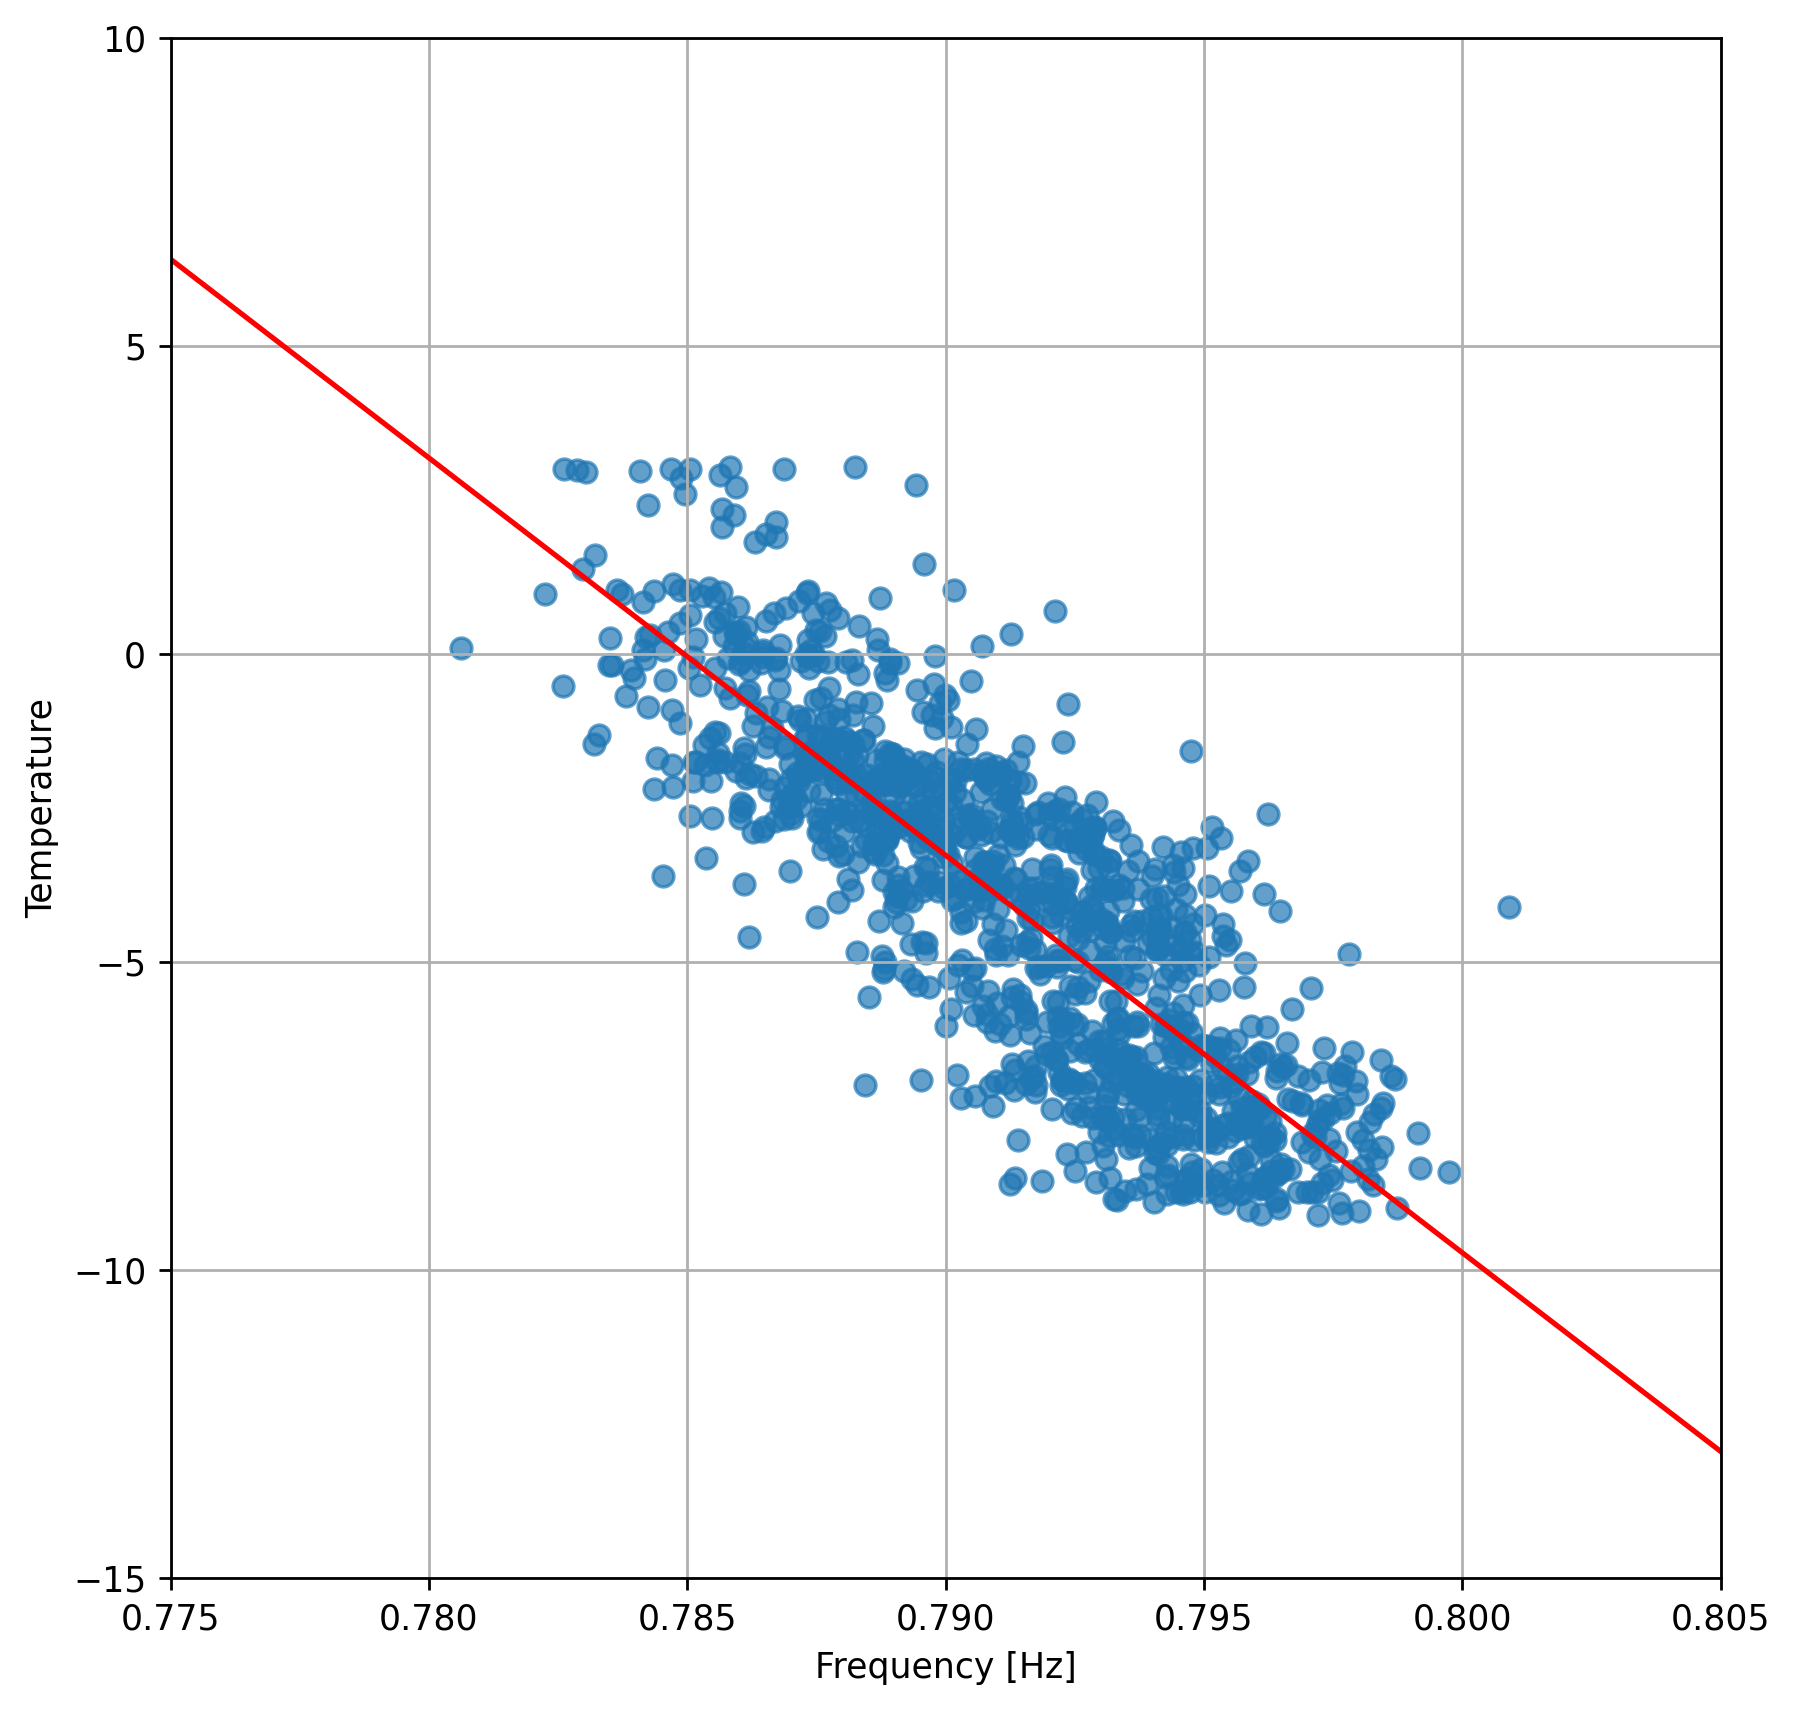

In [9]:
#Find regression line
b, a = np.polyfit(np.array(high_freqs), np.array(temps), deg=1)
xseq = np.linspace(0, 10, num=len(temps))

plt.figure(figsize=(8,8), dpi=300)
plt.scatter(np.array(high_freqs), np.array(temps), alpha=0.7)
plt.plot(xseq, a+b*xseq, color='red')
plt.xlim([0.775, 0.805])
plt.ylim([-15,10])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Temperature')
plt.grid()
plt.savefig('plots/high_freq_temp_correlation.jpg')

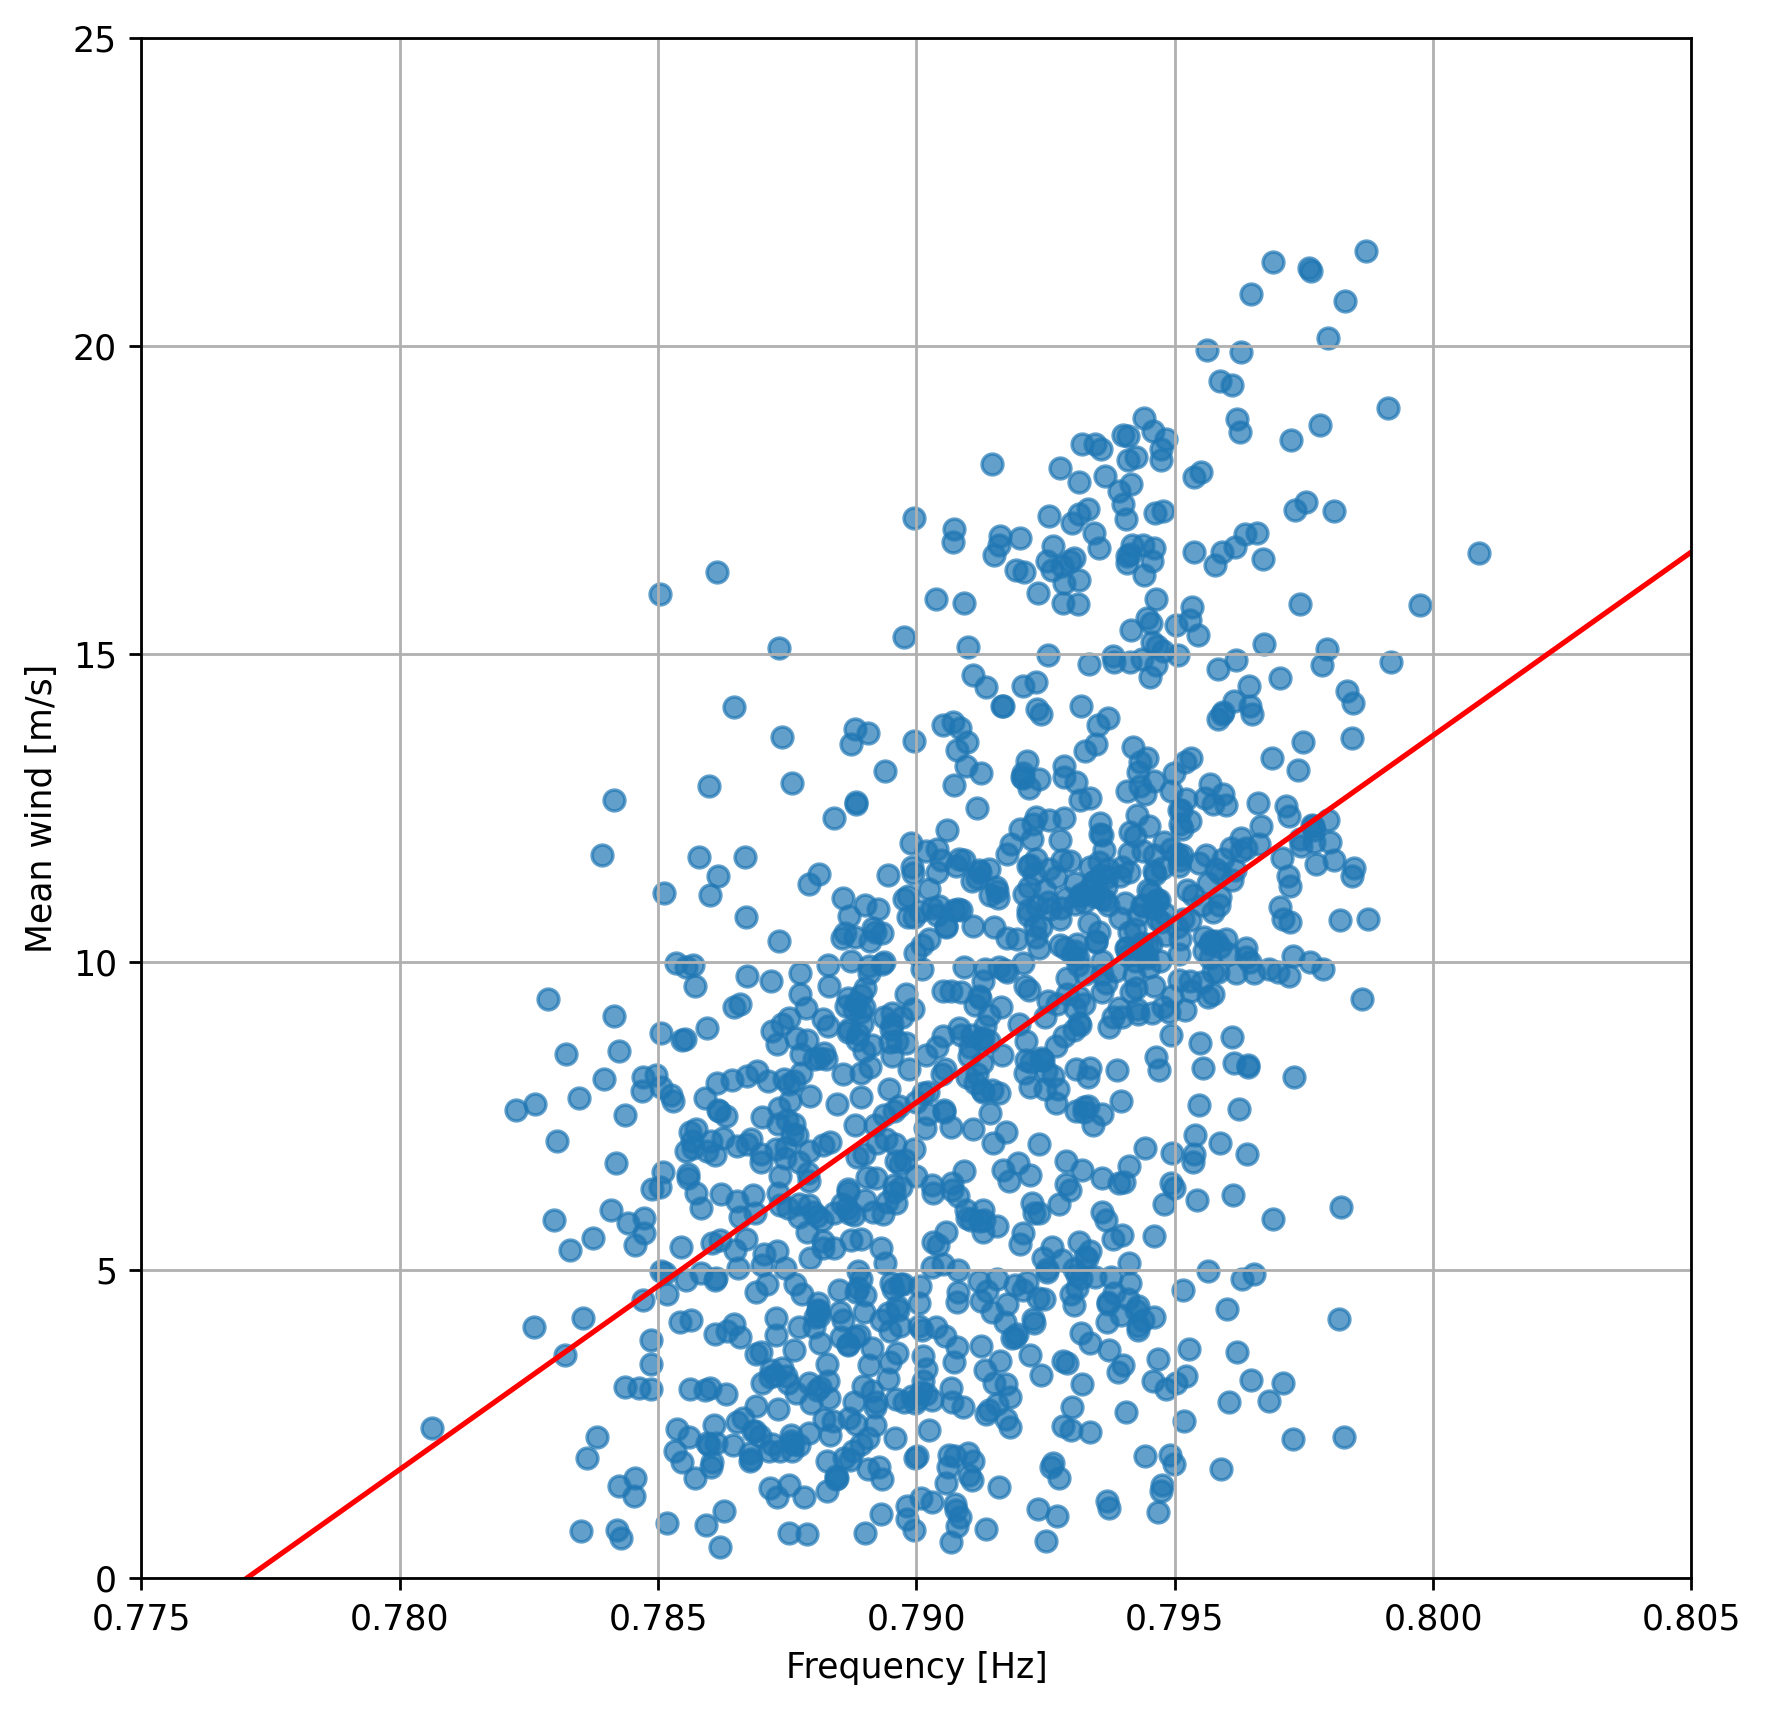

In [10]:
#Find regression line
b, a = np.polyfit(np.array(high_freqs), np.array(mean_wind), deg=1)
xseq = np.linspace(0, 10, num=len(temps))

plt.figure(figsize=(8,8), dpi=300)
plt.scatter(np.array(high_freqs), np.array(mean_wind), alpha=0.7)
plt.plot(xseq, a+b*xseq, color='red')
plt.xlim([0.775, 0.805])
plt.ylim([0,25])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mean wind [m/s]')
plt.grid()
plt.savefig('plots/high_freq_wind_correlation.jpg')

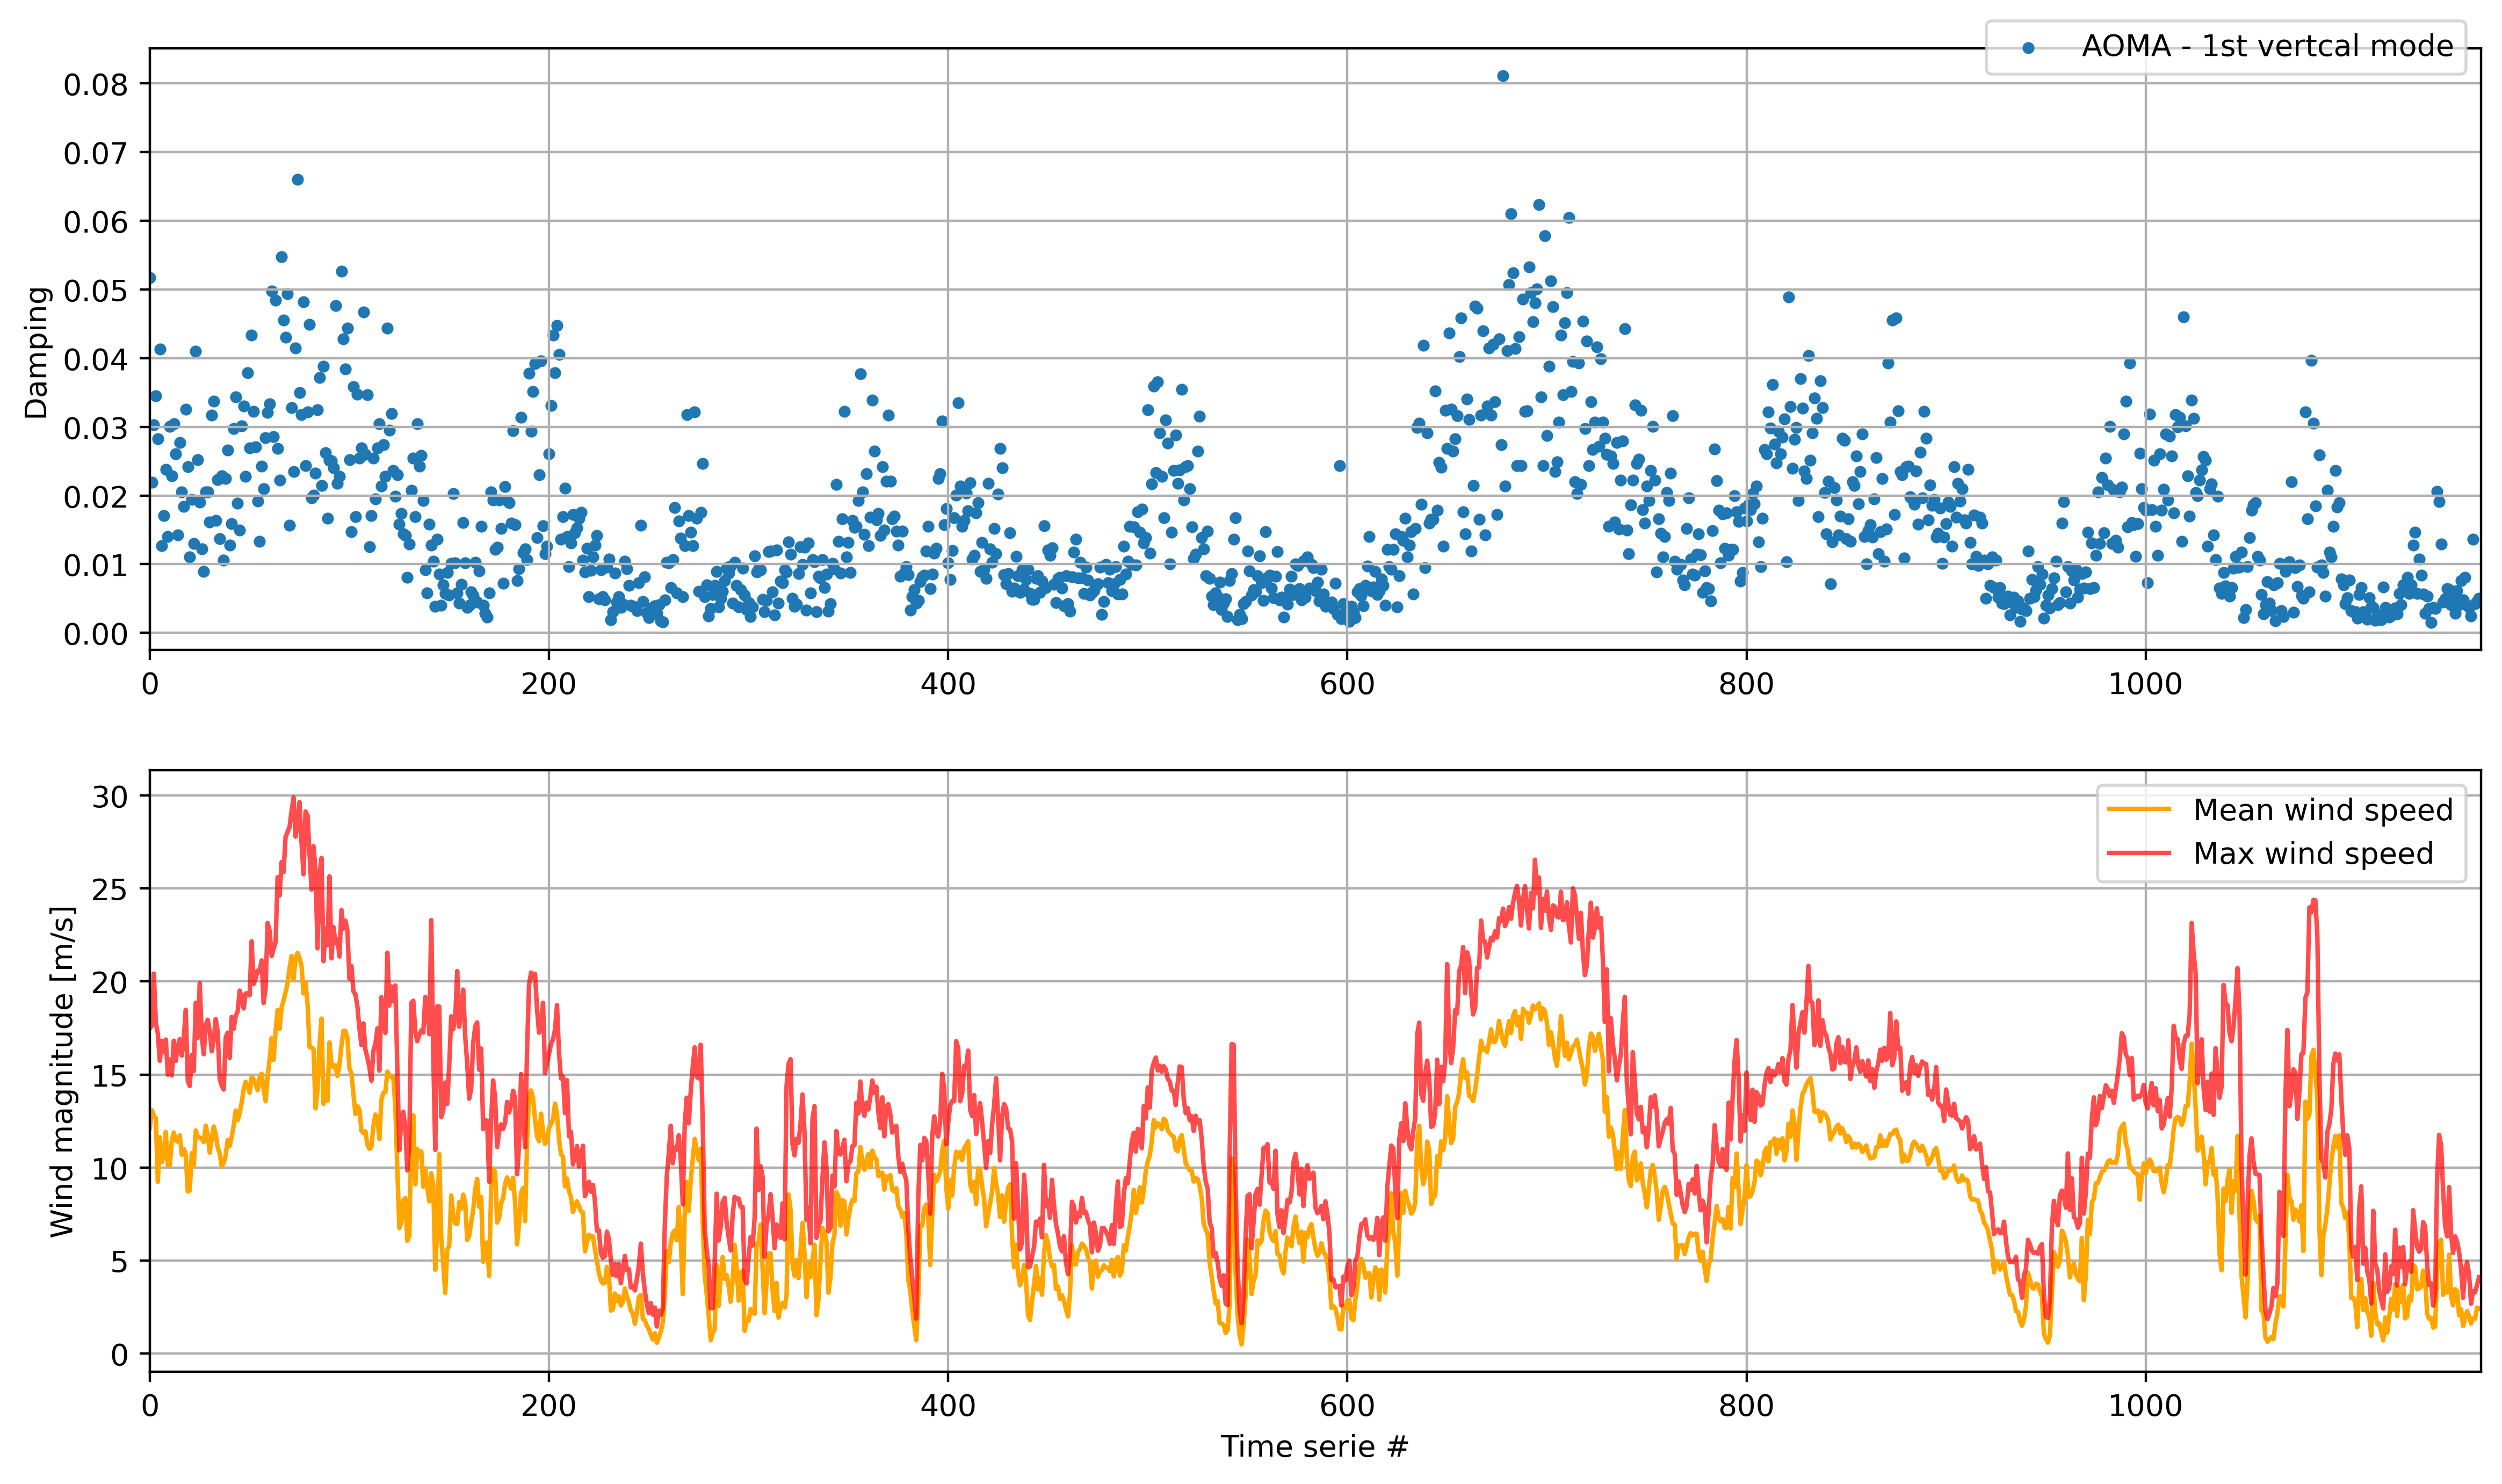

In [11]:
fig, (a1, a3) = plt.subplots(2,1, figsize=(14, 8), dpi=400, gridspec_kw={'height_ratios': [2, 2]})

"""
a1.axhline(y = f[0], color='r', linestyle = '--', alpha = 0.5, label = 'FEM')
for i in range(len(f)-1):
    a1.axhline(y = f[i+1], color='r', linestyle = '--', alpha = 0.5)
"""

a1.scatter(np.arange(0, len(low_mode_damping)), np.array(low_mode_damping), marker='.', label = 'AOMA - 1st vertcal mode')
#a1.plot(np.arange(0, len(low_mode_damping)), np.array(low_mode_damping))
a1.set_xlim((0, len(mean_wind)))
a1.set_ylabel('Damping')
a1.legend(loc = 'upper right', bbox_to_anchor=(1, 1.07))
plt.xlabel('Time serie #')
a1.grid()

#a2 = a1.twinx()
#a2.plot(np.arange(0, len(execution_time)), np.array(execution_time), label = 'Execution time')
a3.plot(np.arange(0, len(mean_wind)), np.array(mean_wind), label = 'Mean wind speed', color='orange')
a3.plot(np.arange(0, len(mean_wind)), np.array(max_wind), label = 'Max wind speed', color='red', alpha=0.7)
a3.set_xlim((0, len(mean_wind)))
a3.set_ylabel('Wind magnitude [m/s]')
a3.legend(loc = 'upper right', bbox_to_anchor=(1, 1))
a3.grid()
plt.savefig('plots/damping_vs_time.jpg')

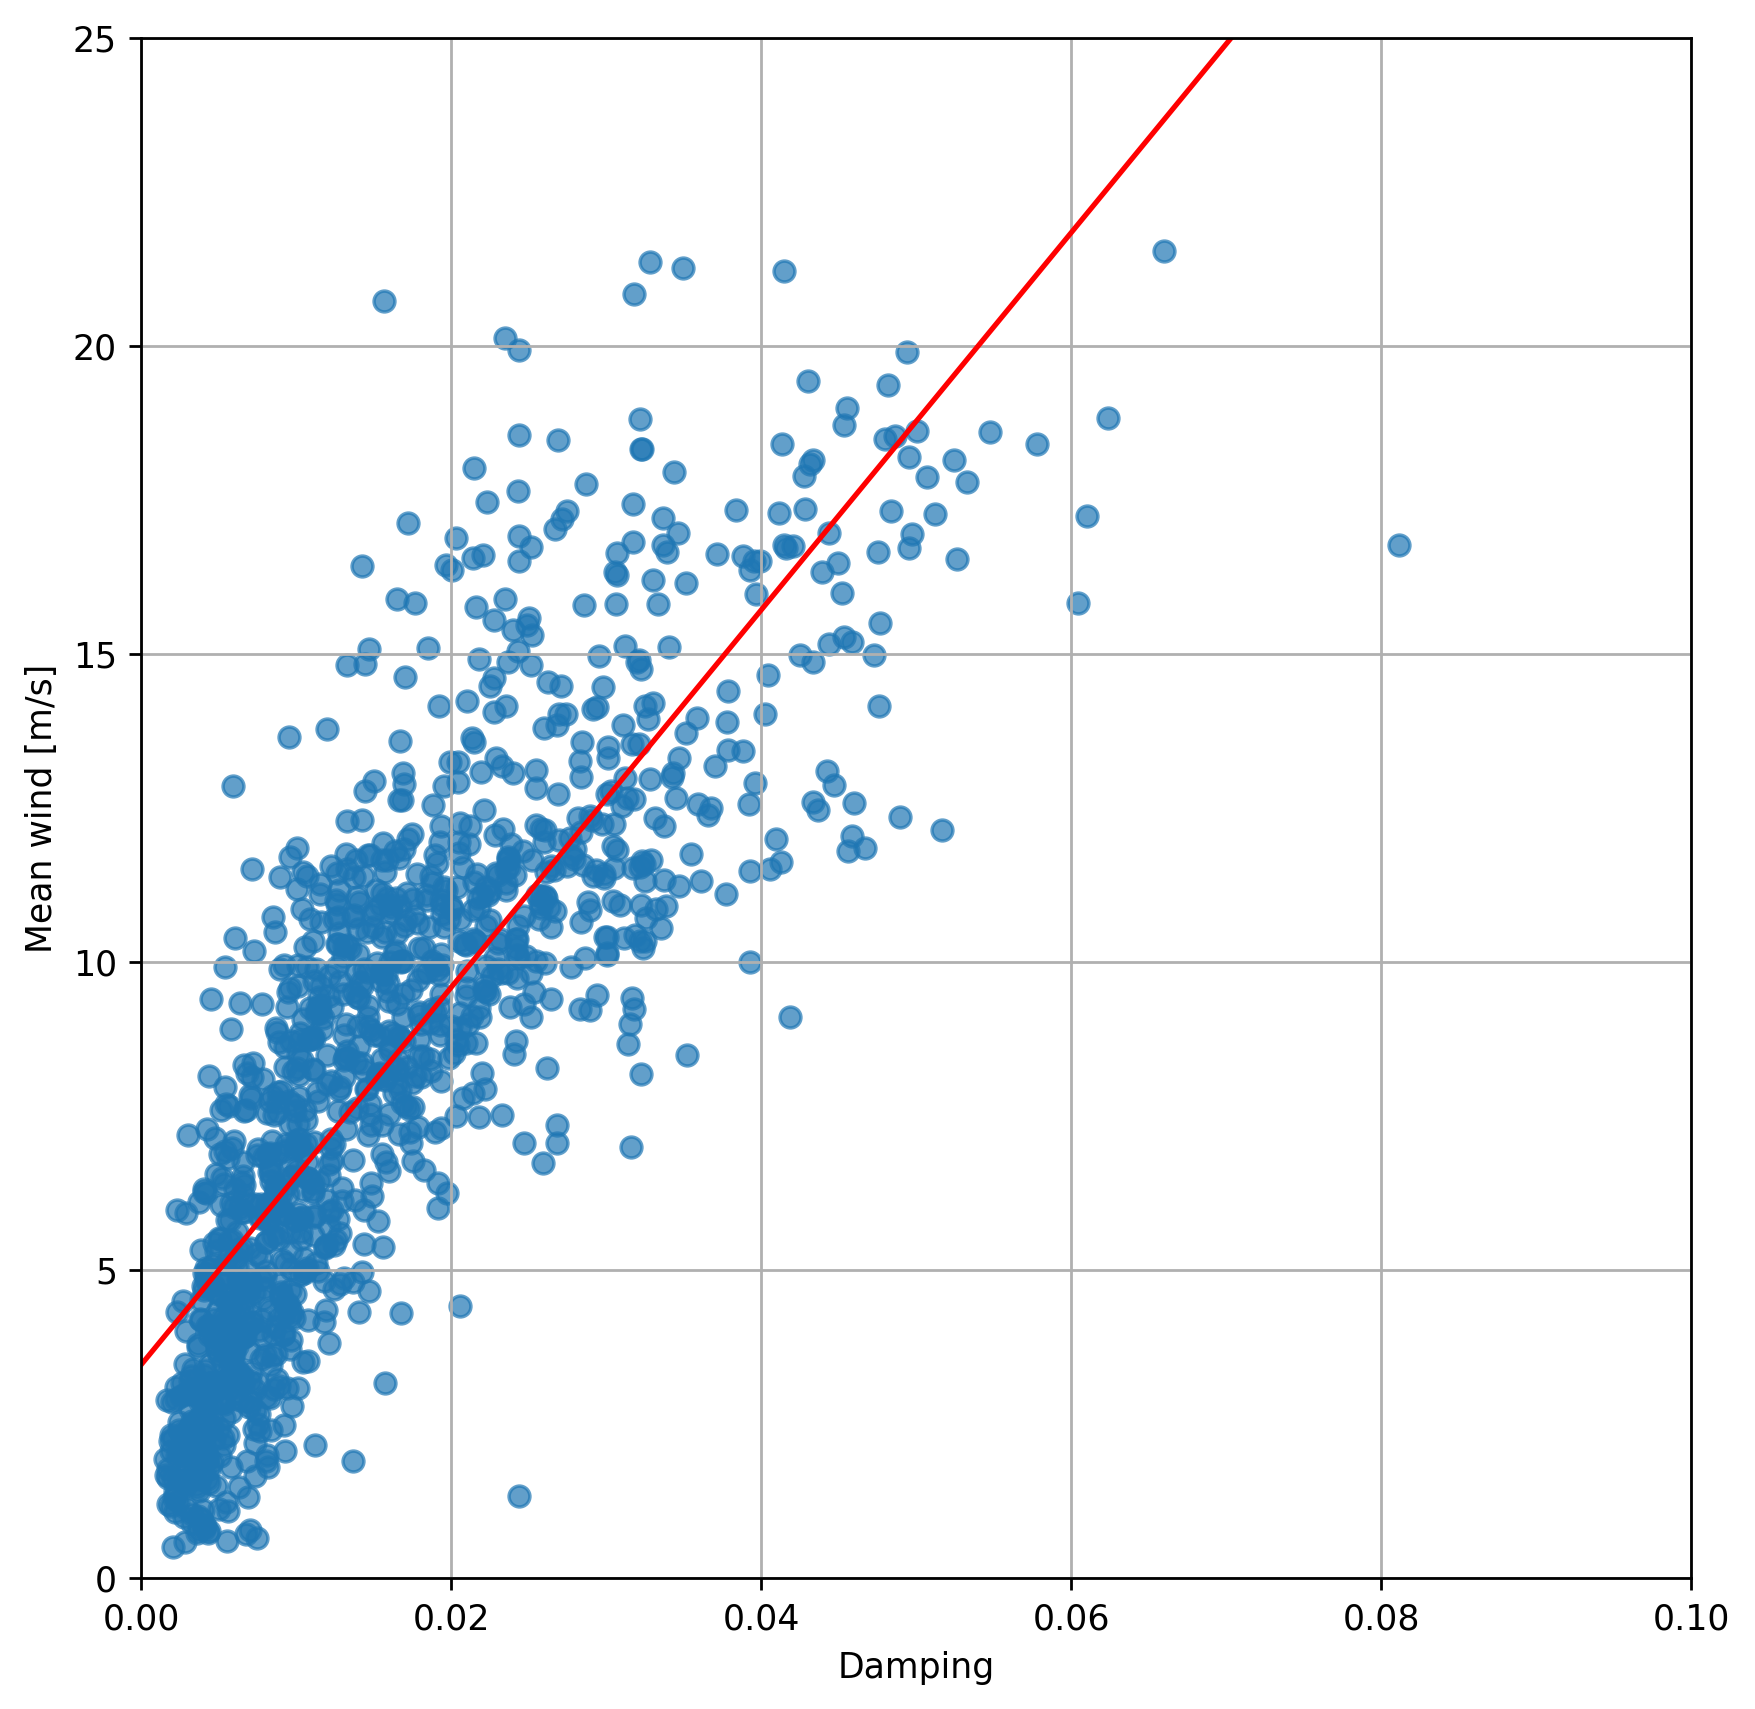

In [12]:
#Find regression line
b, a = np.polyfit(np.array(low_mode_damping), np.array(mean_wind), deg=1)
xseq = np.linspace(0, 10, num=len(mean_wind))

plt.figure(figsize=(8,8), dpi=300)
plt.scatter(np.array(low_mode_damping), np.array(mean_wind), alpha=0.7)
plt.plot(xseq, a+b*xseq, color='red')
plt.xlim([0, 0.10])
plt.ylim([0,25])
plt.xlabel('Damping')
plt.ylabel('Mean wind [m/s]')
plt.grid()
plt.savefig('plots/low_moda_damping_wind_correlation.jpg')